In [9]:
### import and initialize modules ###
%load_ext autoreload
%autoreload 2

%matplotlib inline
# ! if you want to use this, run  'conda install -c conda-forge scalene' for your conda env
#%load_ext scalene 
# ! Or 'conda install -c conda-forge line_proimgr' for this one.
%load_ext line_profiler
import sys
import os
import time
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # You might have to install this into your environment
import scipy.stats as stats 

sys.path.append("../code")
from registration import joint_histogram
from registration_project import rigid_reg_cc_demo, affine_reg_cc_demo, affine_reg_mi_demo, absolute_error_histograms


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [3]:
### import and read data ###
path = '..\data\image_data'

# Get the list of images
images = os.listdir(path)
images.sort()

image_pairs = []
grouped_images = {}

# Group images by their first three characters (I don't know if this is best)
for img in images:
    start = img[:3]  # Get the first three characters of the img name
    if start in grouped_images:
        grouped_images[start].append(img)
    else:
        grouped_images[start] = [img]

# Create pairs
for key, group in grouped_images.items():
    # Sort the group (optional, to maintain a consistent order)
    group.sort()
    
    # Create all possible pairs from the group
    if len(group) > 1:
        image_pairs.extend(list(combinations(group, 2)))

print(image_pairs)

[('1_1_t1.tif', '1_1_t1_d.tif'), ('1_1_t1.tif', '1_1_t2.tif'), ('1_1_t1_d.tif', '1_1_t2.tif'), ('1_2_t1.tif', '1_2_t1_d.tif'), ('1_2_t1.tif', '1_2_t2.tif'), ('1_2_t1_d.tif', '1_2_t2.tif'), ('1_3_t1.tif', '1_3_t1_d.tif'), ('1_3_t1.tif', '1_3_t2.tif'), ('1_3_t1_d.tif', '1_3_t2.tif'), ('2_1_t1.tif', '2_1_t1_d.tif'), ('2_1_t1.tif', '2_1_t2.tif'), ('2_1_t1_d.tif', '2_1_t2.tif'), ('2_2_t1.tif', '2_2_t1_d.tif'), ('2_2_t1.tif', '2_2_t2.tif'), ('2_2_t1_d.tif', '2_2_t2.tif'), ('2_3_t1.tif', '2_3_t1_d.tif'), ('2_3_t1.tif', '2_3_t2.tif'), ('2_3_t1_d.tif', '2_3_t2.tif'), ('3_1_t1.tif', '3_1_t1_d.tif'), ('3_1_t1.tif', '3_1_t2.tif'), ('3_1_t1_d.tif', '3_1_t2.tif'), ('3_2_t1.tif', '3_2_t1_d.tif'), ('3_2_t1.tif', '3_2_t2.tif'), ('3_2_t1_d.tif', '3_2_t2.tif'), ('3_3_t1.tif', '3_3_t1_d.tif'), ('3_3_t1.tif', '3_3_t2.tif'), ('3_3_t1_d.tif', '3_3_t2.tif')]


In [20]:
### Registration ###
# input:
# image_pairs
# general learning rate
# iteration limit

# output: 
# [list] computation times per formula: rigid_cc_time, affine_cc_time, affine_mi_time --> no processing is done with this, these are nice-to-haves
# [list] computation times per type of registration: time_rigid, time_affine, time_rigid_all, time_affine_all
# [list] affine transformation matrices per registration: transformations (rot, scalex, scaley, shearx, sheary, translatex, translatey)

time_rigid = []
time_affine = []
time_rigid_all = []
time_affine_all = []
transformations = []

for img1,img2 in image_pairs[:10]:
    # get image data
    img1 = os.path.join('..\data\image_data',img1)
    img2 = os.path.join('..\data\image_data',img2)
    
    ########## decision
    I = plt.imread(img1)
    J = plt.imread(img2)   
    I = I.reshape((I.shape[0]*I.shape[1],1)).astype(float)
    J = J.reshape((J.shape[0]*J.shape[1],1)).astype(float)

    # if the range is not specified use the min and max values of the
    # inputs
    minmax_range = np.array([min(min(I),min(J)), max(max(I),max(J))])

    # this will normalize the inputs to the [0 1] range
    I = (I-minmax_range[0]) / (minmax_range[1]-minmax_range[0])
    J = (J-minmax_range[0]) / (minmax_range[1]-minmax_range[0])

    # and this will make them integers in the [0 (num_bins-1)] range
    I = np.round(I*(16-1)).astype(int)
    J = np.round(J*(16-1)).astype(int)

    AEH = absolute_error_histograms(I, J,imshow=False)
    affine = True if AEH > 0.9 else False
    rigid = not affine

    ####### rigid_reg_cc_demo
    s = time.time()
    res = rigid_reg_cc_demo(img1,img2,False)
    e = time.time()
    timed = e - s

    # change transformation into form (rot, scalex, scaley, shearx, sheary, translatex, translatey)
    res = [res[0],1,1,0,0,res[1],res[2]]

    time_rigid_all.append(timed)
    if rigid:
        transformations.append(res)
        time_rigid.append(timed)
    else:
        time_rigid.append(0)


    ######## affine_reg_cc_demo
    s = time.time()
    res = affine_reg_cc_demo(img1,img2,False)
    e = time.time()
    timed = e - s

    time_affine_all.append(timed)
    if affine:
        transformations.append(res)
        time_affine.append(timed)
    else:
        time_affine.append(0)


print(time_rigid)
print(time_affine)
print(time_rigid_all)
print(time_affine_all)
print(transformations)

Final similarity of ca. 0.999745973667367
Final similarity of ca. 0.9299874408059998
Final similarity of ca. 0.8158496904868576
Final similarity of ca. 0.6727038994847933
Final similarity of ca. 0.8158496904868576
Final similarity of ca. 0.6727038994847933
Final similarity of ca. 0.722372125096662
Final similarity of ca. 0.7692302930448702
Final similarity of ca. 0.764425460205394


In [18]:
# Test variables to test statistical analysis(assume dataset of 10)
time_rigid = [64098,23249,0,0,57892,0,43897,0,0,0]
time_affine = [0,0,98022,78923,0,298200,0,89023,67239,29870]
time_rigid_all = [64098,23249,24798,58302,57892,42309,43897,28342,8902,78230]
time_affine_all = [78934,57832,98022,78923,78923,298200,83450,89023,67239,29870]
transformations = [[35,2.5,1.1,0.5,1,3,2],[12,1,2,1.6,1.1,0.3,4],[4,1.9,2.1,4,8,0,7],[2,1.2,1.4,2,3,1.5,1],[60,2.3,1.9,1.3,0.4,2,0],[34,1.4,2.2,6,3,0.4,0],[5,1,4.2,1.8,1.2,0.5,1.1],[0,2,1.2,0.3,0.1,1,1.7],[1,1,2.1,0.8,0.2,2,4],[9,1,1.2,0.8,0.2,2,2]]

Variance of comp. time for all rigid transformations:  424242879.89
Variance of comp. time for all affine transformations:  4862675666.639999
Variance of comp. time for the chosen transformations:  5570605978.41
t test affine_all>rigid_all:  Ttest_indResult(statistic=2.1883712672394346, pvalue=0.02103570283721172)
t test affine_all>aggr:  Ttest_indResult(statistic=0.3230839013374063, pvalue=0.375177385807674)


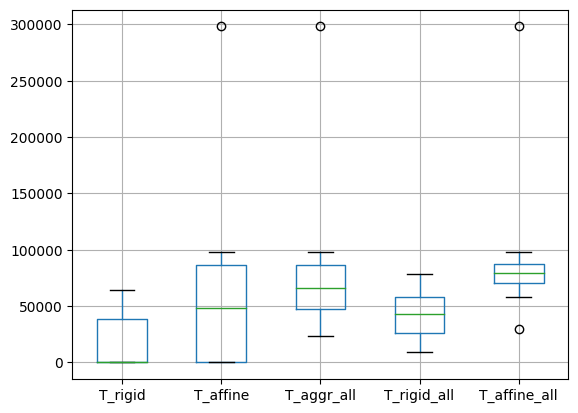

In [19]:
### Statistical analysis ###
# input: list of computation times per formula: rigid_cc_time, affine_cc_time, affine_mi_time --> no processing is done with this, these are nice-to-haves
# input: list of computation times per type of registration: time_rigid, time_affine, time_rigid_all, time_affine_all
# input: list of affine transformation matrices per registration: transformations (rot, scalex, scaley, shearx, sheary, translatex, translatey)

# output: significance testing between the types of registration
# output: power analysis of significance testing
# output: Boxplots for the computation time data spread


aggr_rigid_affine = [time_rigid[i]+time_affine[i] for i in range(len(time_rigid))] # List containing all tests, containing the time using our chosen method
data = np.hstack((time_rigid, time_affine, aggr_rigid_affine, time_rigid_all, time_affine_all))
df_time = pd.DataFrame({'T_rigid': time_rigid,
                        'T_affine': time_affine,
                        'T_aggr_all': aggr_rigid_affine,
                        'T_rigid_all': time_rigid_all,
                        'T_affine_all': time_affine_all})
box = df_time.boxplot(grid=True)
box.plot(figsize=(1,3), title="Boxplot of computation time of rigid and affine transformation registration")

# Test for equal variance
print("Variance of comp. time for all rigid transformations: ",np.var(a=df_time['T_rigid_all']))
print("Variance of comp. time for all affine transformations: ",np.var(a=df_time['T_affine_all']))
print("Variance of comp. time for the chosen transformations: ",np.var(a=df_time['T_aggr_all']))
     

# Variance vary less than factor 4:
    # Test if the computation time to use affine transformation compared to rigid transformation is longer
print("t test affine_all>rigid_all: ",stats.ttest_ind(a=df_time['T_affine_all'],b=df_time['T_rigid_all'], equal_var=True,alternative='greater')) 

    # Test if the aggregated computation time is shorter than all affine registration  
print("t test affine_all>aggr: ",stats.ttest_ind(a=df_time['T_affine_all'],b=df_time['T_aggr_all'], equal_var=True,alternative='greater'))

ValueError: cannot reshape array of size 70 into shape (10,6)

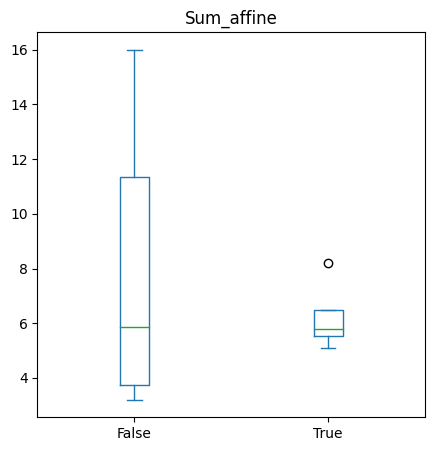

In [17]:
# See if our decision program is working well
rigid_decision = np.array([True if time_rigid[i]>0 else False for i in range(len(time_rigid))]) # Records if rigid was chosen

data2 = [rigid_decision]
sum_affine = [transformations[i][1]+transformations[i][2]+transformations[i][3]+transformations[i][4] for i in range(len(transformations))]
df_transform = pd.DataFrame({"Decision": rigid_decision,
                             "Sum_affine": sum_affine})
box2 = df_transform.plot.box(column="Sum_affine",by="Decision",figsize=(5,5)) # Boxplot that sums the affine parameters and groups them by our decision

# Basic statistics of the average shear and scaling present 
    # Scaling
print("Mean of all scaling: ",np.mean(np.array(transformations).reshape(10,6)[:,1:3]))
print("Mean of scaling of rigid: ", np.mean(np.array(transformations).reshape(10,6)[rigid_decision,1:3]))
print("Mean of scaling of affine: ", np.mean(np.array(transformations).reshape(10,6)[~rigid_decision,1:3]))

print("Variance of all scaling: ",np.var(np.array(transformations).reshape(10,6)[:,1:3]))
print("Variance of scaling of rigid: ", np.var(np.array(transformations).reshape(10,6)[rigid_decision,1:3]))
print("Variance of scaling of affine: ", np.var(np.array(transformations).reshape(10,6)[~rigid_decision,1:3]))

    #Shear
print("Mean of all shear: ",np.mean(np.array(transformations).reshape(10,6)[:,3:5]))
print("Mean of shear of rigid: ", np.mean(np.array(transformations).reshape(10,6)[rigid_decision,3:5]))
print("Mean of shear of affine: ", np.mean(np.array(transformations).reshape(10,6)[~rigid_decision,3:5]))

print("Variance of all shear: ",np.var(np.array(transformations).reshape(10,6)[:,3:5]))
print("Variance of shear of rigid: ", np.var(np.array(transformations).reshape(10,6)[rigid_decision,3:5]))
print("Variance of shear of affine: ", np.var(np.array(transformations).reshape(10,6)[~rigid_decision,3:5]))